# COGS 108 - Final Project 

# Overview

The research analyzes the relationship between the popularity index of parks managed by the City of San Diego Parks & Recreation Department and their characteristics, including the type of the park, the size of it, median household income of the area the park in, and the number of recreational facilities in it. For each park I gathered these characteristics and analysed in what degree they affect the populatity of the park. As the result of the analysis I discovered that there is a small correlation between the area of the park and it's popularity.

# Name & GitHub

- Name: Nikita Ravlyuk
- GitHub Username: nravlyuk

# Research Question

Which characteristics of a park have the largest effect on how popular the park is?

## Background and Prior Work

Voice of San Diego raised the problem that the City of San Diego does not fund parks [1]. In a sense it's a bold statement and I think that it should be formulated in a bit different way: does City of San Diego funds park efficiently?

The new development plan from the city shifts the standards from the number of **acres** provided to the “value a park delivers to **residents**, taking into account proposed **amenities** and recreational activities” [2]. Why don't we take the next step and verify how much the proposed characteristics affect the popularity of parks and try to predict which characteristics of the *successful* parks can be adopted to find the way to predict the popularity of the new parks?

The idea is to find the dependency between the popularity of a park, and the possible characteristics that might affect it. For this research the features are going to be explored include the area size, type, number of recreational facilities within the park and the median household income of the area where the park is located. Finding which features affect the customer satisfaction the most will help to find the focus on which improvements should be prioritized and help to distribute the budget in the right fields for the best effect [3].

This research uses the concept of weighted (specific case of bayesian) rating to form the popularity index based on the Yelp average rating and the number of reviews [4]. The reason for that is the both average rating and number of reviews are important in calculating the popularity. Rating of 5.0 with only 1 review should be considered less popular than rating of 4.5 with 242 reviews. 

References:
- 1) https://www.voiceofsandiego.org/topics/opinion/improving-san-diegos-parks-will-take-more-input-and-money/
- 2) https://www.kusi.com/san-diego-asks-for-public-input-on-new-master-parks-plan/
- 3) https://www.sandiego.gov/sites/default/files/fiscal_year_2020_parks_and_recreation_department_capital_improvement_program_adopted_budget.pdf
- 4) https://www.evanmiller.org/bayesian-average-ratings.html

# Hypothesis


Some parks are much more popular and preferred for recreational activities over the others. Distinguishing the trends and predicting the location a new park or recreation center should be opened is going to potentially improve the customer happiness the most and will utilize the maximum effect and off-load the limited budged, and as a result, increase average satisfaction over all the parks.

I hypothesize that the type of a park, the provided recreational facilities and the median income of the area where the park is located will have the most impact on how popular the park is. In the other hand the area of the park will have as little as no effect on the popularity as "new development plan from the city shifts the standards from the number of acres..." [2].

# Dataset(s)

- Dataset Name: San Diego Parks Yelp Data
- Link to the dataset: https://www.yelp.com/ (curated by Prof Ellis)
- Number of observations: 833

The dataset consists of 833 entries of information about parks in San Diego area.

- Dataset Name: Household income dataset
- Link to the dataset: https://datasurfer.sandag.org
- Number of observations: 1238

The dataset consists of the information about the number of households within income categories over the neighbourhoods (zip code) in San Diego. It also includes the median of the household income within the specific area (zip code).

- Dataset Name: Park Locations Data
- Link to the dataset: https://data.sandiego.gov/datasets/park-locations/
- Number of observations: 2769

The dataset includes properties, their locations and features managed by the City of San Diego Parks & Recreation Department.

- Dataset Name: Recreation Center Locations
- Link to the dataset: https://data.sandiego.gov/datasets/recreation-center-locations/
- Number of observations: 57

The dataset includes the locations and features of Recreation centers operated by the City of San Diego Park and Recreation Department.

All the datasets will be combined into the DataFrame which consists of the parks maintained by City of San Diego Park and Recreation Department, and their features. The features are going to incude the name of the park, type of the park, total area, it's zip code, median household income within this zip code, number of recreational facilities on it's territory, and a popularity index of this park that is going to be calculated based on Yelp reviews.

# Setup

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import patsy
import statsmodels.api as sm

# Data Cleaning

**Yelp reviews dataset**

First step is to import the Yelp dataset, extract the zip code of the reviewed park and to drop unnecesary columns. By doing so we see that some of the parks are located in Tijuana, Mexico, and a couple doesn't have zip-codes. Dropping them we decrease the number of rows from 833 to 828.

In [2]:
# Import income data / find the zip-code of the park
df_yelp = pd.read_csv("../data/yelp_SD_parks.csv")
df_yelp['zip'] = df_yelp.apply(lambda row: row.address[-5:] if row.address[-5:-4] == "9" else np.nan, axis = 1) 
# Drop unnecesary columns
df_yelp = df_yelp.drop(columns=['address', 'phone', 'id', 'url', 'is_closed'])
# Drop outlier rows
df_yelp = df_yelp.dropna()
df_yelp['zip'] = df_yelp['zip'].astype(int)
df_yelp.head()

,name,rating,review_count,longitude,latitude,zip
0,Balboa Park,5.0,2105,-117.153150,32.734502,92101
1,Civita Park,4.5,46,-117.147278,32.778315,92108
2,Waterfront Park,4.5,242,-117.172479,32.721952,92101
3,Trolley Barn Park,4.5,102,-117.143789,32.762463,92116
4,Bay View Park,5.0,42,-117.178967,32.701785,92118


**Median household income dataset**

The second dataset we import is *household income* dataset. We drop unnecesary columns and filter out only rows that consist the information about median household income within the zip.


In [3]:
# Import income data / gather the median household income values pre index
df_median_income = pd.read_csv("../data/SD_income_censusacs_2010.csv")
df_median_income = df_median_income.rename(columns={"Zip": "zip", "YEAR": "year", "INCOME": "income", "NUMBER": "median_income"})
df_median_income = df_median_income[df_median_income.income == "median income"]
df_median_income = df_median_income.dropna()
df_median_income = df_median_income.drop(columns=['year', 'income'])
df_median_income.head()

,zip,median_income
1130,91901,80513
1131,91902,76075
1132,91905,53429
1133,91906,53627
1134,91910,54288


Now we can merge both datasets. After merging every park consists information about the median household income in the park's area. As expected, we also filter out parks which are located outside of San Diego area (*example*: Dana Point, which is in Orange County), downsizing the number of parks to 793 rows. 

In [4]:
# Add median income of the neighbourhood to the yelp reviews
df = df_yelp.merge(df_median_income, on='zip', how='inner')
df.head()

,name,rating,review_count,longitude,latitude,zip,median_income
0,Balboa Park,5.0,2105,-117.153150,32.734502,92101,49158
1,Waterfront Park,4.5,242,-117.172479,32.721952,92101,49158
2,Pioneer Park,4.0,55,-117.177081,32.749802,92101,49158
3,Harbor Island Park,4.5,71,-117.209091,32.725170,92101,49158
4,Golden Hill Park,4.0,35,-117.137259,32.720764,92101,49158


**Park Locations Dataset**

Next dataset we import is *parks geolocation dataset*. As we are going to use it to map the location of the parks from the Yelp reviews to the parks from geolocation dataset, we also need to convert longitude and latitude of the park to the POINT object. We will call the column of the POINT coordinates - *geometry*.

In [5]:
# Import parks geolocation data
gdf_sd = gpd.read_file("../data/parks_datasd.geojson")
gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
df = df.drop(columns=['longitude', 'latitude'])
df.head()

,name,rating,review_count,zip,median_income,geometry
0,Balboa Park,5.0,2105,92101,49158,POINT (-117.15315 32.73450)
1,Waterfront Park,4.5,242,92101,49158,POINT (-117.17248 32.72195)
2,Pioneer Park,4.0,55,92101,49158,POINT (-117.17708 32.74980)
3,Harbor Island Park,4.5,71,92101,49158,POINT (-117.20909 32.72517)
4,Golden Hill Park,4.0,35,92101,49158,POINT (-117.13726 32.72076)


Next, we need to map the parks from Yelp reviews to the ones from Parks geolocation dataset to find parks' types and sizes.

In [6]:
# Find the park and gather information about the park type and size.
def find_polygon(point):
    for index, row in gdf_sd.iterrows():
        if row['geometry'].contains(point):
            return row['park_type'], row['gis_acres'], row['geometry']
    return np.nan, np.nan, np.nan

temp = df.apply(lambda row: find_polygon(row.geometry), axis = 1)
t1=[]
t2=[]
t3=[]
for t in temp:
    t1.append(t[0])
    t2.append(t[1])
    t3.append(t[2])
df['type'] = t1
df['acres'] = t2
df = df.drop(columns=['geometry'])
df['geometry'] = t3
df= df.dropna()

df.head()

,name,rating,review_count,zip,median_income,type,acres,geometry
0,Balboa Park,5.0,2105,92101,49158,Regional,1089.476460,"(POLYGON ((-117.15295972 32.74370296, -117.152..."
1,Waterfront Park,4.5,242,92101,49158,Regional,12.693865,"POLYGON ((-117.17155566 32.72449793, -117.1727..."
2,Pioneer Park,4.0,55,92101,49158,Local,11.353881,"(POLYGON ((-117.17663874 32.74977954, -117.176..."
4,Golden Hill Park,4.0,35,92101,49158,Regional,1089.476460,"(POLYGON ((-117.15295972 32.74370296, -117.152..."
8,Balboa Park Kids Playground,4.0,13,92101,49158,Regional,1089.476460,"(POLYGON ((-117.15295972 32.74370296, -117.152..."


After doing so we observe that the number of entries decreased from 793 to 218 rows. We verify that entries like *Pushkin Russian Restaurant* dissapeared, leaving us with the reviews of only needed parks. We can also observe some duplicates as one park can be within another (*example*: Golden Hill Park is within Balboa Park). To address this issue we can drop least popular parks which are located within the lerger park.

In [7]:
#Remove all the duplicates
acs = set()
def mark_duplicates(acres):
    if acres in acs:
        return np.nan
    acs.add(acres)
    return True
df['popularity'] = df.apply(lambda row: row['rating'] * np.log(row['review_count']), axis = 1) #placeholder for sort purpose
df = df.sort_values(by=['popularity'], ascending=False)
df = df.reset_index(drop = True)
df['mark'] = df.apply(lambda row: mark_duplicates(row.acres), axis = 1)
df = df.dropna()
df = df.drop(columns=['mark', 'popularity'])
df.head()

,name,rating,review_count,zip,median_income,type,acres,geometry
0,Balboa Park,5.0,2105,92101,49158,Regional,1089.476460,"(POLYGON ((-117.15295972 32.74370296, -117.152..."
2,Torrey Pines State Reserve,4.5,1319,92037,94084,State,1466.798603,"(POLYGON ((-117.25091718 32.93199299, -117.253..."
3,Cowles Mountain,4.5,945,92119,74070,Open Space,381.708900,"POLYGON ((-117.03315905 32.80337005, -117.0308..."
4,Mount Soledad National Veterans Memorial,5.0,421,92037,94084,Local,118.536897,"POLYGON ((-117.24837347 32.83987831, -117.2471..."
5,Cabrillo National Monument,4.5,681,92106,75830,National,153.276913,"POLYGON ((-117.24161697 32.67721691, -117.2416..."


As we can see, we reduced our dataset to 157 unique parks.

**Rec Center Locations Data**

Now when we have all the parks we are interested in, we can count how many recreational facilities a park holds. For that firstly we need to import *Rec Center Locations Dataset*. Then we will cound the number of recreational facilities that are located in our parks.

In [8]:
# Import Rec Center Locations Dataset and find number of rec facilities in parks
gdf_rec = gpd.read_file("../data/rec_centers_datasd.geojson")

def find_rec(geometry):
    number_rec = 0
    for index, row in gdf_rec.iterrows():
        if geometry.contains(row['geometry']):
            number_rec += 1
    return number_rec

df['rec_facility_cnt'] = df.apply(lambda row: find_rec(row.geometry), axis = 1)

In [9]:
print("The total number of recreational facilities found in the park: {}".format(sum(df['rec_facility_cnt'])))

The total number of recreational facilities found in the park: 24


**Weighted Popularity**

As our research question tries to predict characteristics that makes the park popular, we need to calculate the popularity index for each park from Yelp reviews. The formula we are going to use is:

\begin{align}
P & = ((\frac{v}{v+m}R) + (\frac{m}{v+m}C)) \log{v} \\
\end{align}

Where,
* P is weighted rating (popularity)
* v is the number of reviews for the park
* m is the minimum votes required to be listed
* R is the average rating of the park
* C is the mean vote across the whole report

In [10]:
# Apply popularity fornm
m = 1
C = df['rating'].mean()

df['popularity'] = df.apply(lambda row: ((row['review_count']/(row['review_count'] + m) * row['rating']) + (m/(row['review_count'] + m) * C))*(np.log(row['review_count'])+1), axis = 1) 

**Final DataFrame**

In [11]:
df = df.drop(columns=['geometry'])
df = df.sort_values(by=['popularity'], ascending=False)
df = df.reset_index(drop = True)
df

,name,rating,review_count,zip,median_income,type,acres,rec_facility_cnt,popularity
0,Balboa Park,5.0,2105,92101,49158,Regional,1089.476460,3,43.256612
1,Torrey Pines State Reserve,4.5,1319,92037,94084,State,1466.798603,0,36.828284
2,Cowles Mountain,4.5,945,92119,74070,Open Space,381.708900,0,35.326923
3,Mount Soledad National Veterans Memorial,5.0,421,92037,94084,Local,118.536897,0,35.197964
4,Cabrillo National Monument,4.5,681,92106,75830,National,153.276913,0,33.851498
...,...,...,...,...,...,...,...,...,...
152,Vista Pacifica Park,4.0,1,92154,55077,Local,6.872379,0,4.044586
153,Wightman Street Neighborhood Park,4.0,1,92105,36738,Local,0.970419,0,4.044586
154,Teralta Park,3.0,1,92105,36738,Local,5.096408,0,3.544586
155,Nestor Neighborhood Park,2.0,1,92154,55077,Local,4.987712,0,3.044586


# Data Analysis & Results

**Popularity**

First of all let's look at the distribution of the popularity index.

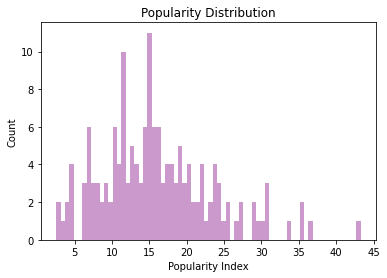

In [12]:
ax = sns.distplot(df['popularity'], bins=70, color="purple", norm_hist=False, kde=False)
ax.set_title('Popularity Distribution')
ax.set_xlabel('Popularity Index')
ax.set_ylabel('Count')
plot1 = plt.gcf()

As we can see the distribution of the weighted popularity index is normally distributed.

**Area**

Secondly, let's look at the distribution of the area among parks.

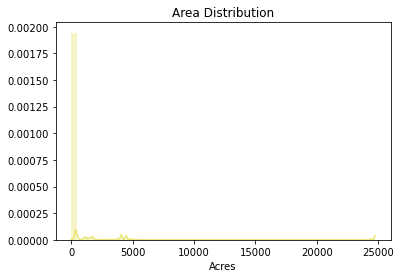

In [13]:
ax = sns.distplot(df['acres'], color="#EBE674",)
ax.set_title('Area Distribution')
ax.set_xlabel('Acres')
plot2 = plt.gcf()

As we can see there is an outlier whick makes our task a little bit complicated. To fix this issue we can log the acres to see better distribution

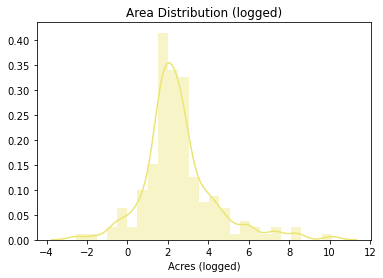

In [14]:
df['acres_log'] = df.apply(lambda row: np.log(row['acres']), axis = 1)
ax = sns.distplot(df['acres_log'], color="#EBE674",)
ax.set_title('Area Distribution (logged)')
ax.set_xlabel('Acres (logged)')
plot3 = plt.gcf()

As we can see, now the are of the parks seems being more normally distributed.

To check the correlation between area an popularity, let's make a scatterplot.

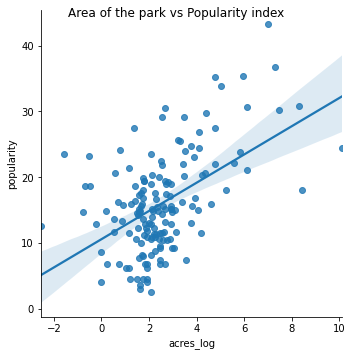

In [15]:
sns.lmplot(x='acres_log',y='popularity',data=df).fig.suptitle("Area of the park vs Popularity index")
plot4 = plt.gcf()

There actually appeared a correlation between the size of the park and it's popularity, although the deviation is pretty big.

**Zip Distribution**

Not let's see how the parks are distributed within different areas (zip codes). To make it easier to see the distribution we'll order the zip codes by number of the parks in the area.

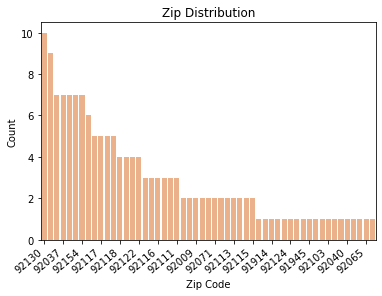

In [16]:
ax = sns.countplot(x="zip", data=df, palette=["#FAAE7B"], order=df['zip'].value_counts().index)
ax.set_title('Zip Distribution')
ax.set_xlabel('Zip Code')
ax.set_ylabel('Count')
xticks=ax.xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i%3>0:
        xticks[i].set_visible(False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plot5 = plt.gcf()

As we can see, the parks are distributed not uniformly. some areas are having 7-10 parks while others only 1.

Note: The x-axis(zip codes) are not coisidered as useful observation here. I included them only for reference as an example.

**Median Household Income**

Next distribution we are going to examine is the median household income in the area where the park located.

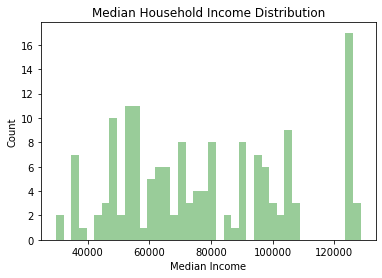

In [17]:
ax = sns.distplot(df['median_income'], bins=40, color="g", norm_hist=False, kde=False)
ax.set_title('Median Household Income Distribution')
ax.set_xlabel('Median Income')
ax.set_ylabel('Count')
plot6 = plt.gcf()

As we can see the median household income is not normally nor evenly distributed among the parks with the outlier at >120000 value.

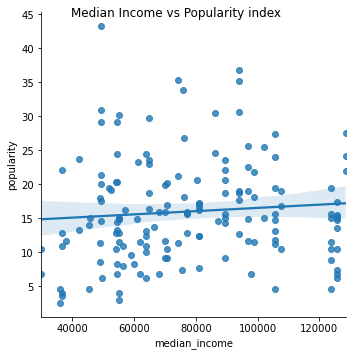

In [18]:
sns.lmplot(x='median_income',y='popularity',data=df).fig.suptitle("Median Income vs Popularity index")
plot7 = plt.gcf()

The correlation between median household income and the popularity of the park appears to be minimal. It seems like the median income of the neighbourhood doesn't affect the popularity of the park.

**Number of recreational facilities**

Let's see the scatter plot for the number of recreational facilities in the park.

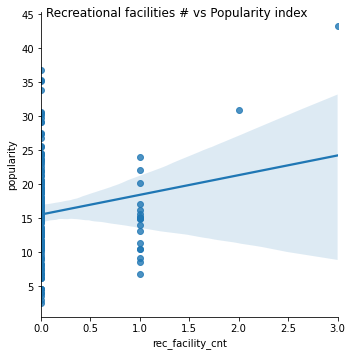

In [19]:
sns.lmplot(x='rec_facility_cnt',y='popularity',data=df).fig.suptitle("Recreational facilities # vs Popularity index")
plot8 = plt.gcf()

It seems like there's a little correlation between the number of recreational facilities in the park and population. But it can also be related to the area of the park or other features.

**Type of the park**

Anf finallu let's look at the distribution of the types of parks.

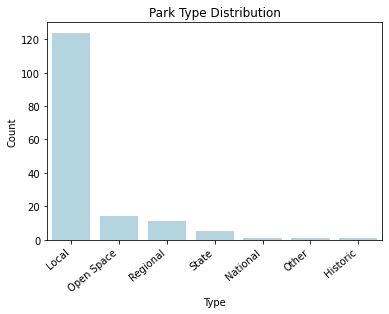

In [20]:
ax = sns.countplot(x="type", data=df, palette=["#add8e6"], order=df['type'].value_counts().index)
ax.set_title('Park Type Distribution')
ax.set_xlabel('Type')
ax.set_ylabel('Count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plot9 = plt.gcf()

As expected the most common type of the park in San Diego is *Local* park. Then we can see that following the leader the number of Open Space and Regional parks are having about the same count. The we have the state parks that are taking the fraction of the total amount of SD parks. And finally the National, Historic and Other types of parks have the minimum count.

**OSL Regression**

Let's build OSL Regression model to verify our observations.

In [21]:
outcome, predictors = patsy.dmatrices('popularity ~ type + acres_log + median_income + rec_facility_cnt', df)
model=sm.OLS(outcome, predictors)
res=model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             popularity   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     9.769
Date:                Wed, 16 Dec 2020   Prob (F-statistic):           1.22e-11
Time:                        21:23:33   Log-Likelihood:                -501.77
No. Observations:                 157   AIC:                             1024.
Df Residuals:                     147   BIC:                             1054.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             16.0667      6

It seems like our features correlated with the popularity at 37% as reported by R-squared metric which is not very significant.

The most significant feature of the park, surprisingly, appeared to be the area of the park. It means that my hypothesis for this research was wrong.

Median household income has a little correlation with popularity but not significant in our case.

The recreational facilities count seems to have little significance as well.

The type of the park seems to be not correlated with the popularity at all. 

# Ethics & Privacy

All of the information for my datasets were acquired from the open source, avoiding collection information manually or from individuals, so without risking of disclosing any private information. 

All the data regarding the projects and the parks themselves is already available as they were processed by the Parks and Recreation department. The records about the region/neighborhood of the park wew aquired from the open detabase service https://datasurfer.sandag.org (SANDAG, U.S. Census Bureau (data extracted on: 12/2020)). 

The issues of privacy, ethics and unreliable/not accurate data should be considered. To solve this problem, I analyze the way the data is collected and make needed adjustments to account the possible error in measurements or the privacy issues. As the information was collected by U.S. Census Bureau, there is no known problem about the unknown way the data was collected and processed. 

The Yelp Reviews data consists only the public information about the facilities and summary of the published reviews. No personal data was recorded or used in this dataset.

The important bias in the dataset and especially in the result is that some projects might be associated with the specific region characteristics like the economical differences and racial diversity. This connection is both statistically important to achieve our goal as well as having some ethical issues which should be avoided. I believe that the way to avoid them is to thoroughly analyze the patterns and the reasons of all the results provided by the model.

# Conclusion & Discussion

This research was designed to find the relation between popularity of the park with the park's characteristics. The analysis showed the small correlation of 37% between the proposed features and the park's popularity index. The most correlated feature appeared to be the area of the park.

These results show that my hypothesis cannot be supported, and the type of the park and the median household income weren't the features that affected the park's popularity the most.

The limitations of this research include the limitations due to constraints on methodology and research design. The possible errors and and unreliable/not accurate conclusions of the research could be the limited or not accurate data as well as the ways I am handling/understanding the data. There also a possibility of some model design decisions that could also lead to some margin of error (*example*: downsizing parks that are located within other parks).

Although my hypothesis for this research wasn't supported, the research question of this project was answered: the area of the park seems to have the largest correlation among the other tested characteristics. The deeper investigation of the proposed as well as other characteristics can be made to have more complete understanding of how can we distinguish the popular parks from less popular ones to increase the overall customer satisfaction and decrease the budget spent. And another possible improvement that could increase the accuracy of the results is the popularity index based on the poll rather than Yelp reviews as the way for it to be more precise and less skewed to  only the Internet/Yelp users.